In [1]:
import torch
import numpy as np
import torchvision
from torchvision import transforms
from PIL import Image
import requests
import time
import numpy as np
import io
from io import BytesIO
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os
from torch.utils.data import Dataset
import torch.nn.init as init
from torch.nn.utils.rnn import pad_sequence
import random
from tqdm import tqdm
import json
from torch.optim.lr_scheduler import CosineAnnealingLR
import threading
import torchvision.models as models
import torch.nn as nn
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel
from nltk.corpus import wordnet
from image_transforms import SimCLRData_image_Transform
from dataset import FlickrDataset,Flickr30kDataset
from model_advml import ResNetSimCLR
from metrics import  intra_ContrastiveLoss ,Optimizer_simclr
from utils import get_gpu_stats,layerwise_trainable_parameters,count_trainable_parameters
from train_fns import train,val,psnr,calculate_psnr
from logger import Logger
from args import args_project

In [4]:
torch.manual_seed(1234)
weights_file='/work/08629/pradhakr/maverick2/advml_project/train_results/image_model1_30k.pth'
batch_size=64
intra_projecton_dim=128
hidden_dim =512
layers_to_train=['layer4']
optimizer_name='sgd'
lr=0.001
momentum=0.9
weight_decay=1e-4
reconstruction_tradeoff=1
contrastive_tradeoff=0
temperature=0.07
noise_amount=0.2
scheduler_image=None
dataset = Flickr30kDataset('/work/08629/pradhakr/maverick2/cv_project/flickr30k-images', 
                           '/work/08629/pradhakr/maverick2/cv_project/flickr30k_captions/results_20130124.token',
                           caption_index_1=0,
                           caption_index_2=1,
                          image_transform=SimCLRData_image_Transform(),
                          noise_transform=True,
                              evaluate=False,
                              noise_amount=noise_amount)
indices = list(range(len(dataset)))
train_indices = indices[:29783]
val_indices = indices[29783:30783]
test_indices = indices[30783:]
train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)
batch_size=batch_size
train_loader = DataLoader(train_set, 
                             batch_size=batch_size, 
                             shuffle=True, 
                             num_workers=4, 
                             pin_memory=True)
val_loader = DataLoader(val_set, 
                         batch_size=batch_size, 
                         shuffle=False, 
                         num_workers=4, 
                         pin_memory=True)
test_loader = DataLoader(test_set, 
                         batch_size=batch_size, 
                         shuffle=False, 
                         num_workers=4, 
                         pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = ResNetSimCLR(
        model='resnet50',
        intra_projection_dim=intra_projecton_dim,
        hidden_dim =hidden_dim,
        layers_to_train=layers_to_train
    ).to(device)
resnet_model.load_state_dict(torch.load(weights_file))
resnet_model.eval()
print('1')
#1.06,-0.26

1


In [5]:
intra_loss=intra_ContrastiveLoss(device,temperature=temperature)
test_loss=val(test_loader,
            resnet_model,
            intra_loss,
            device,
            reconstruction_tradeoff,
            contrastive_tradeoff)
#psnr_loss=calculate_psnr(test_loader, resnet_model,device)
print('test_loss',test_loss)


test_loss 1.0638714507222176


In [4]:
for i in train_loader:
    s=i
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.6249)


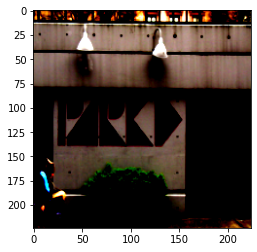

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


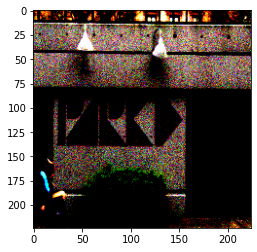

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


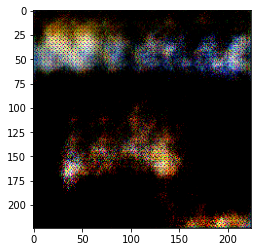

In [21]:
index=2
original_images,noisy_images,contrastive_img1,contrastive_img2=s[0],s[1],s[2],s[3]
output=resnet_model(noisy_images[index].unsqueeze(0), device ,reconstruct=True,contrast=False).squeeze(0).detach().cpu()
print(psnr(original_images,output))
plt.imshow(original_images[index].permute(1,2,0))
plt.show()
plt.imshow(noisy_images[index].permute(1,2,0))
plt.show()
plt.imshow(output.permute(1,2,0))
